In [1]:
import os

import matplotlib.pyplot as plt

from cedtrainscheduler.simulator.config import SimulatorConfig
from cedtrainscheduler.simulator.simulator import Simulator
from cedtrainscheduler.simulator.types import Metrics


def run_simulation(scheduler_name, fs_config_path, jobs_count):
    """运行模拟并返回结果"""
    current_dir = os.getcwd()  # 使用 os.getcwd() 获取当前工作目录
    base_dir = os.path.dirname(current_dir)


    config = SimulatorConfig(
        cluster_config_path=os.path.join(base_dir, "cedtrainscheduler/cases/cluster/cluster_config.json"),
        fs_config_path=os.path.join(base_dir, "cedtrainscheduler/cases/cluster/"+fs_config_path),
        scheduler_name=scheduler_name,
        task_config_path=os.path.join(base_dir, f"cedtrainscheduler/cases/task/case_{jobs_count}_tasks.csv"),
        output_path=os.path.join(base_dir, "examples/outputs"),
    )

    simulator = Simulator(config)
    results = simulator.simulation()
    return results


# 假设 results_dict_light 和 results_dict_heavy 是两个模拟器的结果字典
# 运行不同调度器的模拟
schedulers = ["k8s-data", "k8s", "sjf-data", "sjf", "ced"]
# schedulers = ["greedy", "ced"]
jobs_count_list = [2000]
results_dict_light: dict[int, dict[str, Metrics]] = {}
results_dict_heavy: dict[int, dict[str, Metrics]] = {}

for jobs_count in jobs_count_list:
    results_dict_light[jobs_count] = {}
    results_dict_heavy[jobs_count] = {}
    for scheduler in schedulers:
        # 使用轻量版配置运行模拟
        results_light = run_simulation(scheduler, fs_config_path='fs_config_light.json', jobs_count=jobs_count)
        results_dict_light[jobs_count][scheduler] = results_light
        print(results_light)

        # 使用重版配置运行模拟
        results_heavy = run_simulation(scheduler, fs_config_path='fs_config_heavy.json', jobs_count=jobs_count)
        results_dict_heavy[jobs_count][scheduler] = results_heavy
        print(results_heavy)


Metrics(scheduler_name=<SchedulerType.FCFS_DATA: 1>, task_count=2000, total_runtime=3887789.8944848985, avg_queue_time=581746.7604956089, avg_running_time=601812.7909956084, avg_execution_time=20066.0305, cloud_count=647, edge_count=782, terminal_count=571)
Metrics(scheduler_name=<SchedulerType.FCFS_DATA: 1>, task_count=2000, total_runtime=5412976.94742754, avg_queue_time=1010222.7342636761, avg_running_time=1030027.0812636756, avg_execution_time=19804.347, cloud_count=738, edge_count=516, terminal_count=746)
Metrics(scheduler_name=<SchedulerType.FCFS: 2>, task_count=2000, total_runtime=1840769.3832808905, avg_queue_time=391844.78288192913, avg_running_time=407306.1558819293, avg_execution_time=15461.373, cloud_count=1572, edge_count=330, terminal_count=98)
Metrics(scheduler_name=<SchedulerType.FCFS: 2>, task_count=2000, total_runtime=2114625.7428911366, avg_queue_time=482784.841023317, avg_running_time=498236.70652331697, avg_execution_time=15451.8655, cloud_count=1576, edge_count=326

/var/folders/rb/d6pkdll93l72td23gky3725c0000gn/T/ipykernel_38106/4221641655.py:25: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('Blues', len(results_dict_light) + 2)


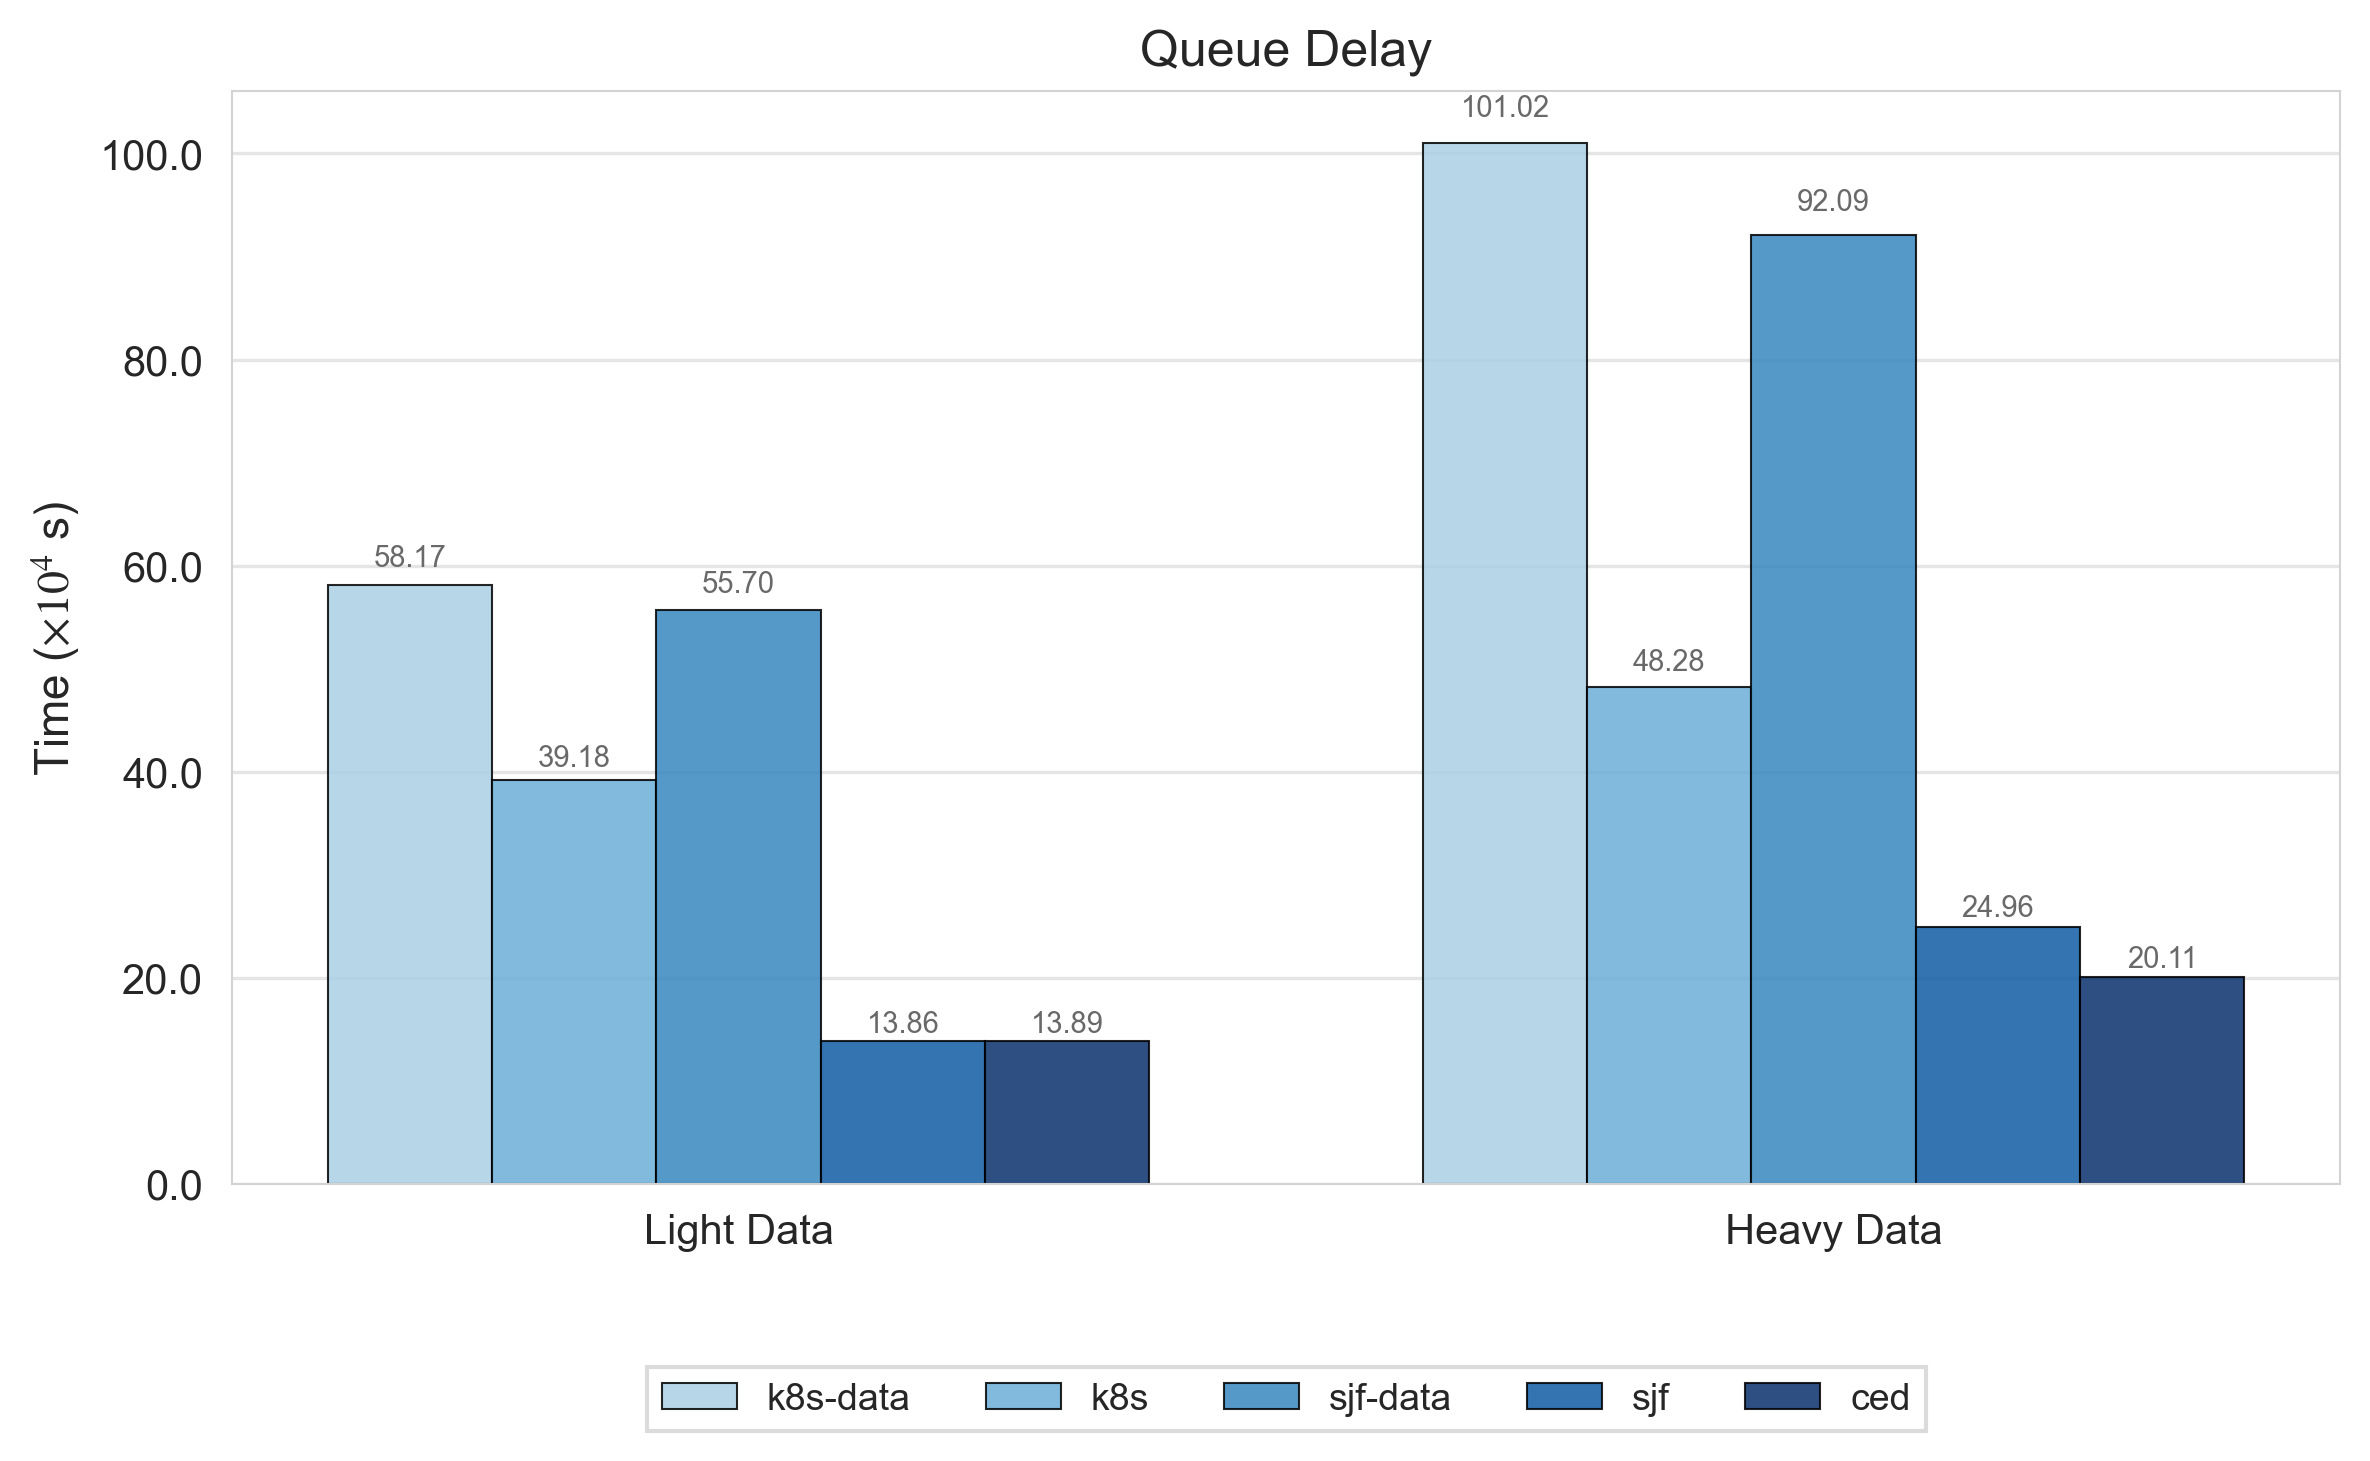

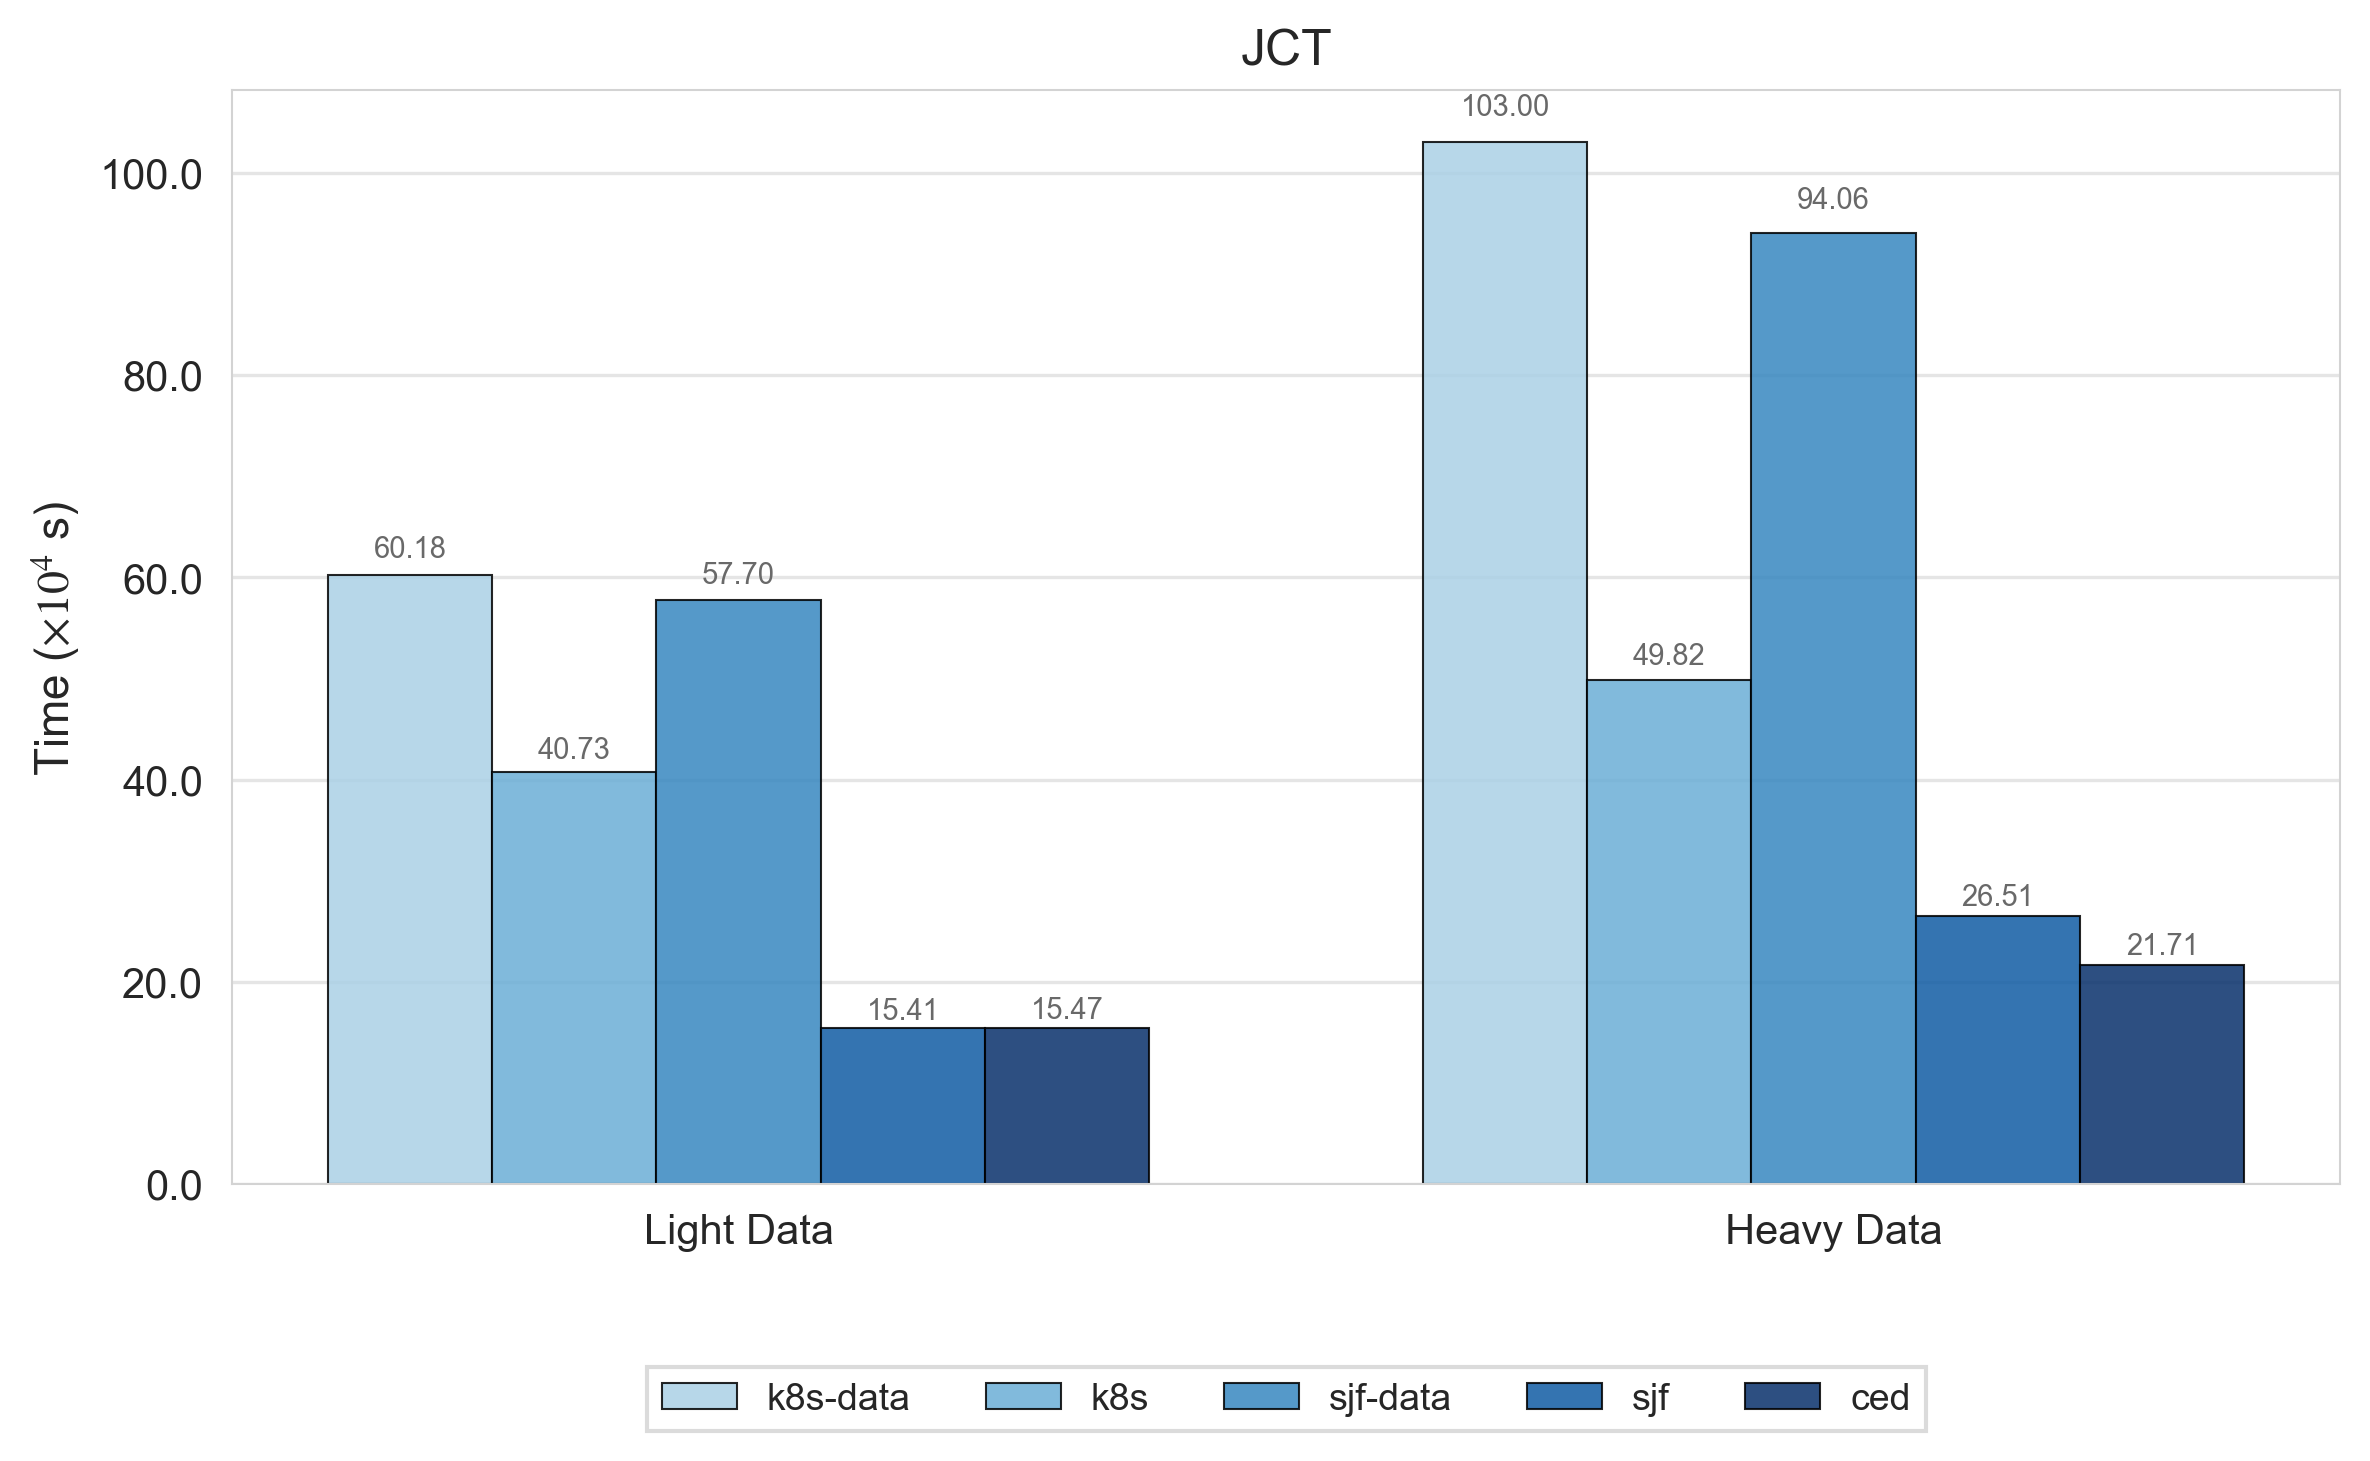

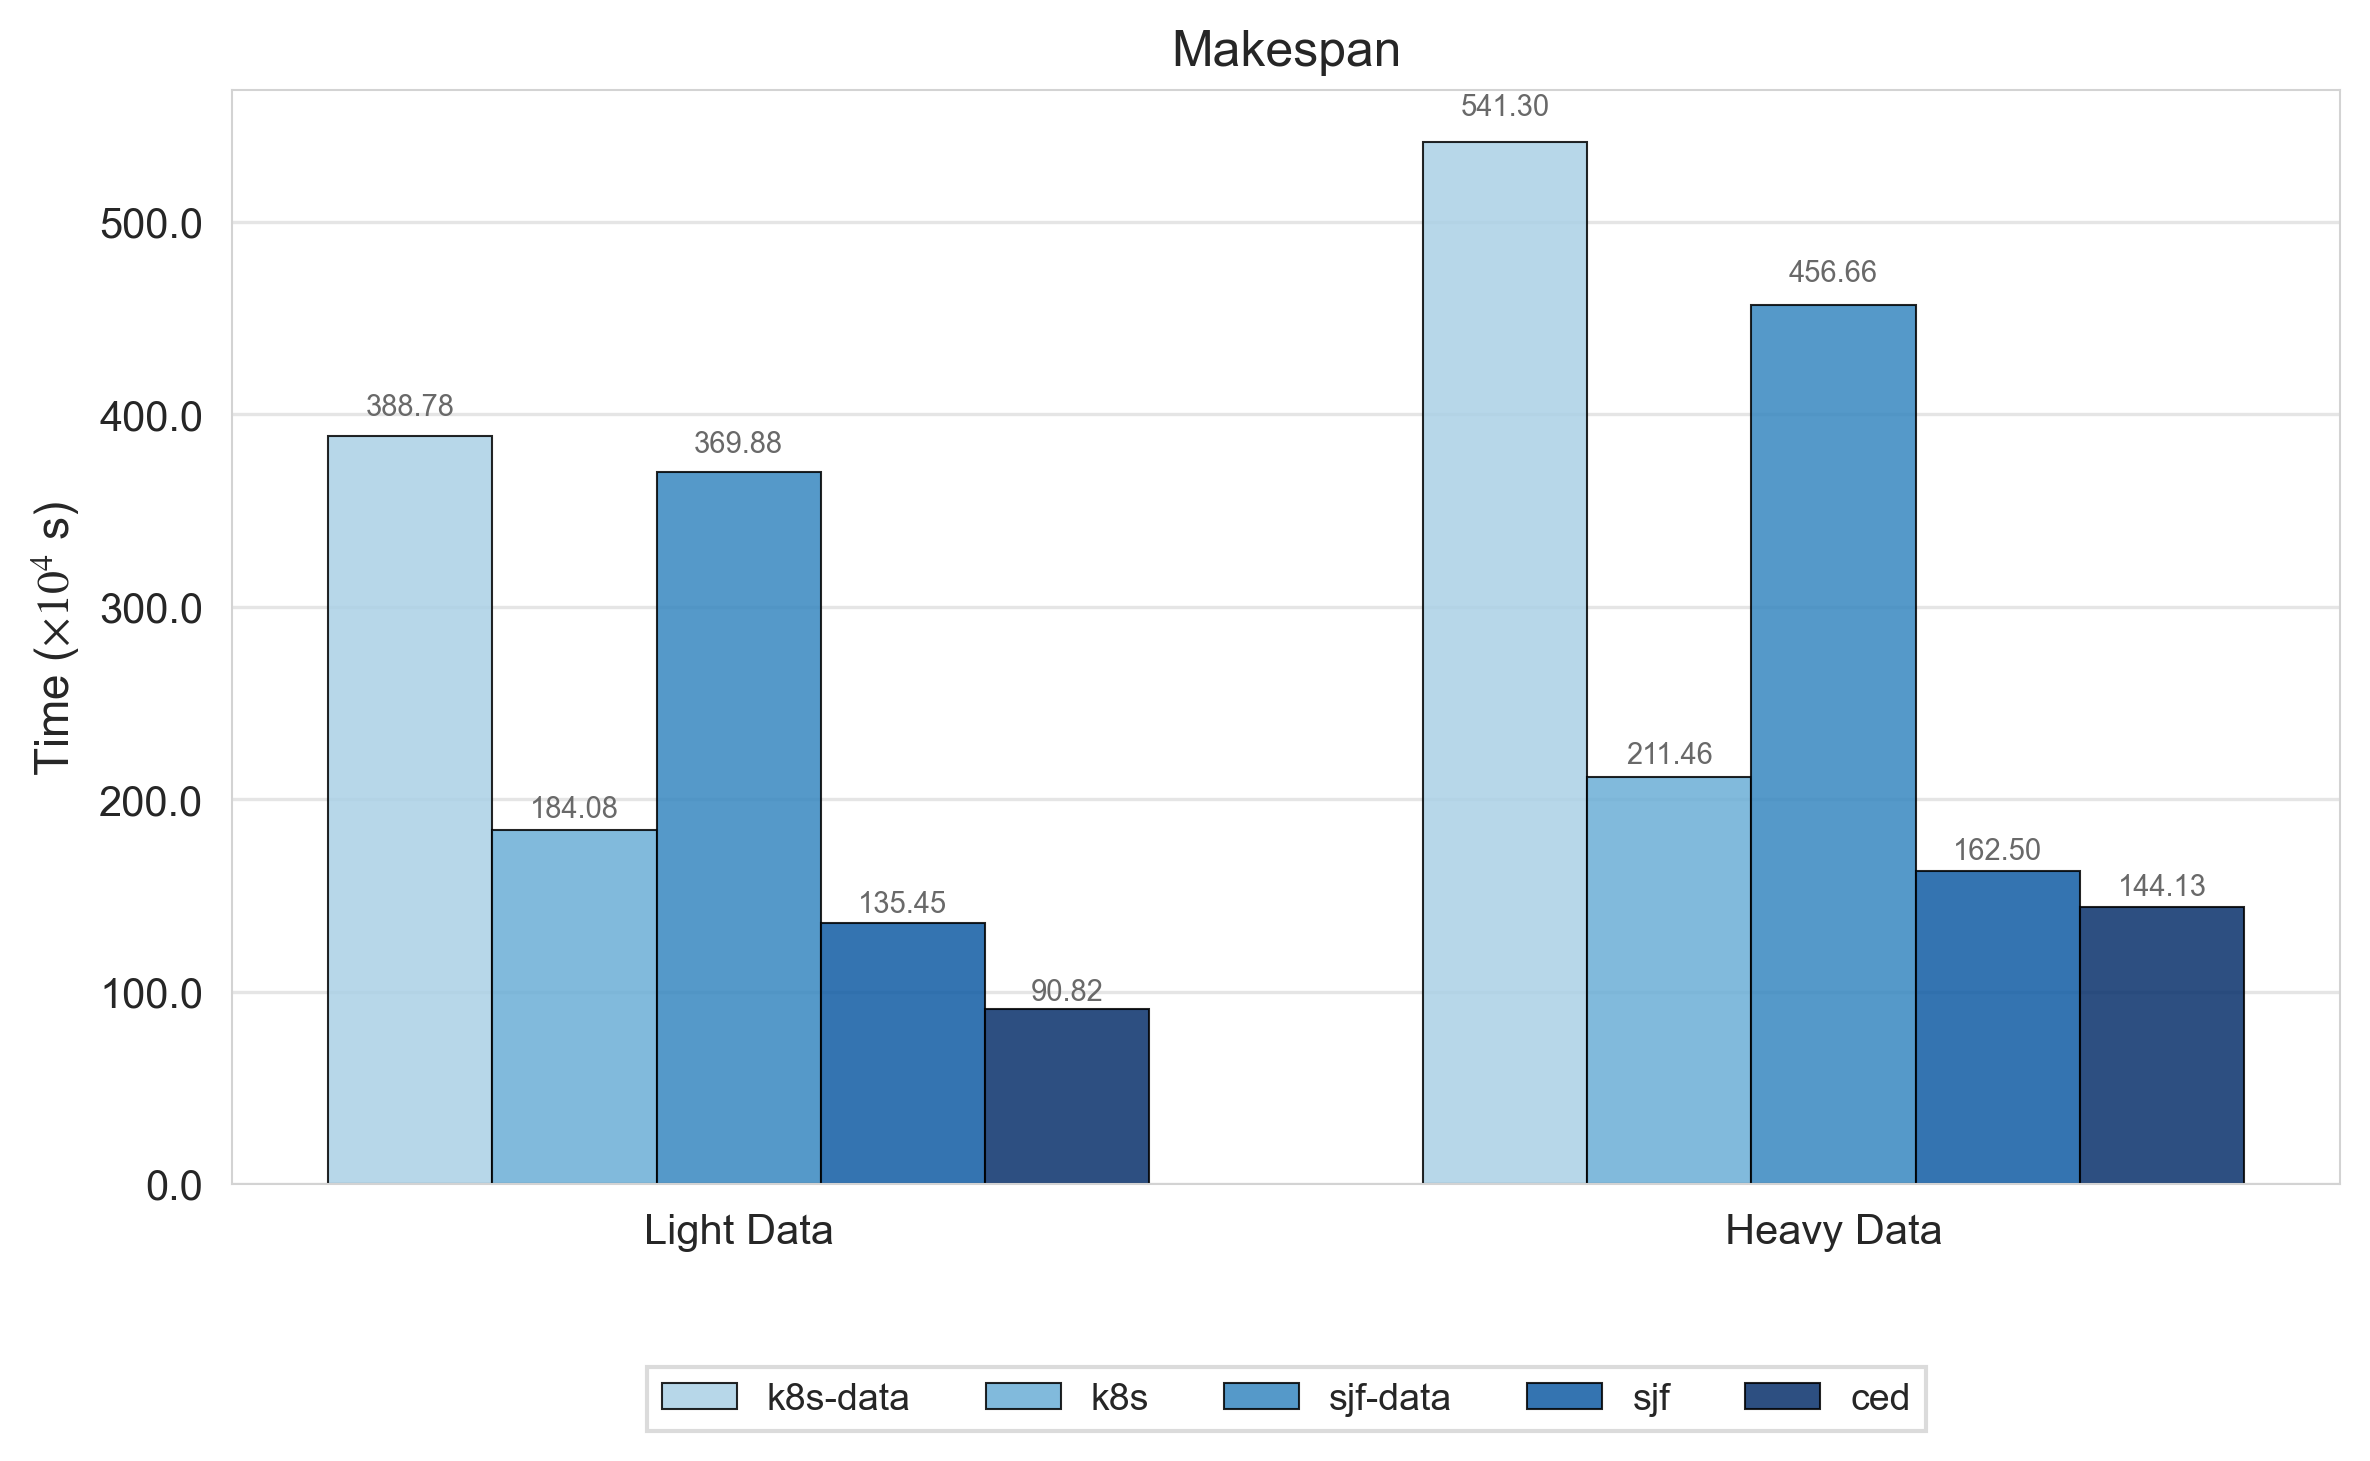

In [2]:
def plot_results(results_dict_light, results_dict_heavy):
    """绘制结果图 - 素雅单色系学术风格"""
    import matplotlib as mpl
    import matplotlib.cm as cm
    import seaborn as sns
    from matplotlib.ticker import FuncFormatter

    # 重置matplotlib参数，避免之前设置的影响
    mpl.rcParams.update(mpl.rcParamsDefault)

    # 设置字体为 serif 风格（类似于高质量学术论文）
    plt.rcParams.update({
        'font.family': 'serif',
        'font.serif': ['Times New Roman', 'DejaVu Serif', 'Palatino', 'serif'],
        'mathtext.fontset': 'stix',
        'axes.labelsize': 11,
        'axes.titlesize': 12,
        'xtick.labelsize': 10,
        'ytick.labelsize': 10,
        'legend.fontsize': 9,
    })

    # 使用单色系配色方案 - 蓝色系
    # 从浅到深的蓝色渐变
    cmap = cm.get_cmap('Blues', len(results_dict_light) + 2)
    blue_palette = [mpl.colors.rgb2hex(cmap(i+2)) for i in range(len(results_dict_light))]

    # 使用简洁的白色背景
    sns.set_style("white")

    # 指标名称
    metrics_names = ['Queue Delay', 'JCT', 'Makespan']
    width = 0.15  # 调整条形图的宽度
    x_positions = [0, 1]  # 0 for light-data, 1 for heavy-data

    # 分别为每个指标创建一个图形窗口
    for metric_name in metrics_names:
        fig, ax = plt.subplots(figsize=(8, 5))  # 更紧凑的图表比例
        fig.set_dpi(300)  # 高分辨率

        bars = []  # 存储条形图对象用于图例

        for i, (scheduler_name, metrics_light) in enumerate(results_dict_light.items()):
            metrics_heavy = results_dict_heavy[scheduler_name]

            if metric_name == 'Queue Delay':
                value_light = metrics_light.avg_queue_time
                value_heavy = metrics_heavy.avg_queue_time
            elif metric_name == 'JCT':
                value_light = metrics_light.avg_running_time
                value_heavy = metrics_heavy.avg_running_time
            elif metric_name == 'Makespan':
                value_light = metrics_light.total_runtime
                value_heavy = metrics_heavy.total_runtime            # 
            # 绘制轻量版和重版的条形图 - 素雅单色系风格
            bar_light = ax.bar(
                x_positions[0] + i * width - (len(results_dict_light) - 1) * width / 2, 
                value_light, 
                width, 
                color=blue_palette[i],
                edgecolor='black',
                linewidth=0.5,
                alpha=0.85,  # 稍微透明以增加素雅感
                label=scheduler_name
            )

            bar_heavy = ax.bar(
                x_positions[1] + i * width - (len(results_dict_light) - 1) * width / 2, 
                value_heavy, 
                width, 
                color=blue_palette[i],
                edgecolor='black',
                linewidth=0.5,
                alpha=0.85  # 稍微透明以增加素雅感
            )
            
            bars.append(bar_light[0])
        
        # 设置图表标题和标签 - 更简洁的风格
        ax.set_title(f'{metric_name}', fontsize=12, fontweight='normal')
        ax.set_ylabel('Time ($\\times 10^4$ s)', fontsize=11)
        ax.set_xticks(x_positions)
        ax.set_xticklabels(['Light Data', 'Heavy Data'], fontsize=10)
        ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: f'{y / 1e4:.1f}'))
        
        # 添加精细的网格线 - 仅水平线，提高可读性
        ax.grid(axis='y', linestyle='-', alpha=0.2, color='gray')
        
        # 将图例放置在图表下方，简洁风格
        ax.legend(
            bars,
            [scheduler for scheduler in results_dict_light.keys()],
            fontsize=9, 
            loc='upper center', 
            bbox_to_anchor=(0.5, -0.15), 
            ncol=len(results_dict_light),
            frameon=True,
            edgecolor='lightgray',
            fancybox=False,
            shadow=False,
        )
        
        # 添加数据标签显示具体值 - 更小更简洁
        for i, (scheduler_name, metrics_light) in enumerate(results_dict_light.items()):
            metrics_heavy = results_dict_heavy[scheduler_name]
            
            if metric_name == 'Queue Delay':
                value_light = metrics_light.avg_queue_time
                value_heavy = metrics_heavy.avg_queue_time
            elif metric_name == 'JCT':
                value_light = metrics_light.avg_running_time
                value_heavy = metrics_heavy.avg_running_time
            elif metric_name == 'Makespan':
                value_light = metrics_light.total_runtime
                value_heavy = metrics_heavy.total_runtime
            
            # 在条形图上方显示数值 - 更小更简洁
            ax.text(
                x_positions[0] + i * width - (len(results_dict_light) - 1) * width / 2,
                value_light * 1.02,
                f'{value_light/1e4:.2f}',
                ha='center', 
                va='bottom', 
                fontsize=7,
                color='dimgray'
            )
            
            ax.text(
                x_positions[1] + i * width - (len(results_dict_light) - 1) * width / 2,
                value_heavy * 1.02,
                f'{value_heavy/1e4:.2f}',
                ha='center', 
                va='bottom', 
                fontsize=7,
                color='dimgray'
            )
        
        # 调整布局
        plt.tight_layout()
        plt.subplots_adjust(bottom=0.2)  # 调整下边距，为图例留出空间
        
        # 添加精细的边框
        for spine in ax.spines.values():
            spine.set_visible(True)
            spine.set_linewidth(0.5)
            spine.set_color('lightgray')
        
        plt.show()


# 一次绘制特定任务数量的图表
def plot_specific_jobs(job_count):
    """绘制特定任务数量的结果比较图"""
    light_results = {scheduler: results_dict_light[job_count][scheduler] for scheduler in schedulers}
    heavy_results = {scheduler: results_dict_heavy[job_count][scheduler] for scheduler in schedulers}
    plot_results(light_results, heavy_results)


plot_specific_jobs(2000)

In [3]:
# 计算 ced 的 JCT 降低百分比相对于其他调度器
def calculate_ced_jct_reduction(results_dict_light, results_dict_heavy):
    jct_reduction_light = {}
    jct_reduction_heavy = {}

    for scheduler in results_dict_light.keys():
        if scheduler == 'ced':
            continue

        jct_ced_light = results_dict_light['ced'].avg_running_time
        jct_ced_heavy = results_dict_heavy['ced'].avg_running_time

        jct_light = results_dict_light[scheduler].avg_running_time
        jct_heavy = results_dict_heavy[scheduler].avg_running_time

        # 计算 ced 相对于其他调度器的降低百分比
        reduction_light = ((jct_light - jct_ced_light) / jct_light) * 100
        reduction_heavy = ((jct_heavy - jct_ced_heavy) / jct_heavy) * 100

        jct_reduction_light[scheduler] = reduction_light
        jct_reduction_heavy[scheduler] = reduction_heavy

    return jct_reduction_light, jct_reduction_heavy

selected_results_dict_light = results_dict_light[2000]
selected_results_dict_heavy = results_dict_heavy[2000]
# 获取 ced 的 JCT 降低百分比
jct_reduction_light, jct_reduction_heavy = calculate_ced_jct_reduction(selected_results_dict_light, selected_results_dict_heavy)

# 输出结果
print("ced 的 JCT 降低百分比相对于其他调度器:")
for scheduler in jct_reduction_light.keys():
    print(f"{scheduler}: Light 情况下降低了 {jct_reduction_light[scheduler]:.2f}%, Heavy 情况下降低了 {jct_reduction_heavy[scheduler]:.2f}%")


# 计算 ced 的 Makespan 降低百分比相对于其他调度器
def calculate_ced_makespan_reduction(results_dict_light, results_dict_heavy):
    makespan_reduction_light = {}
    makespan_reduction_heavy = {}

    for scheduler in results_dict_light.keys():
        if scheduler == 'ced':
            continue

        makespan_ced_light = results_dict_light['ced'].total_runtime
        makespan_ced_heavy = results_dict_heavy['ced'].total_runtime

        makespan_light = results_dict_light[scheduler].total_runtime
        makespan_heavy = results_dict_heavy[scheduler].total_runtime

        # 计算 ced 相对于其他调度器的降低百分比
        reduction_light = ((makespan_light - makespan_ced_light) / makespan_light) * 100
        reduction_heavy = ((makespan_heavy - makespan_ced_heavy) / makespan_heavy) * 100

        makespan_reduction_light[scheduler] = reduction_light
        makespan_reduction_heavy[scheduler] = reduction_heavy

    return makespan_reduction_light, makespan_reduction_heavy

# 获取 ced 的 Makespan 降低百分比
makespan_reduction_light, makespan_reduction_heavy = calculate_ced_makespan_reduction(selected_results_dict_light, selected_results_dict_heavy)

# 输出结果  
print("ced 的 Makespan 降低百分比相对于其他调度器:")
for scheduler in makespan_reduction_light.keys():
    print(f"{scheduler}: Light 情况下降低了 {makespan_reduction_light[scheduler]:.2f}%, Heavy 情况下降低了 {makespan_reduction_heavy[scheduler]:.2f}%")

ced 的 JCT 降低百分比相对于其他调度器:
k8s-data: Light 情况下降低了 74.29%, Heavy 情况下降低了 78.92%
k8s: Light 情况下降低了 62.01%, Heavy 情况下降低了 56.43%
sjf-data: Light 情况下降低了 73.19%, Heavy 情况下降低了 76.92%
sjf: Light 情况下降低了 -0.40%, Heavy 情况下降低了 18.10%
ced 的 Makespan 降低百分比相对于其他调度器:
k8s-data: Light 情况下降低了 76.64%, Heavy 情况下降低了 73.37%
k8s: Light 情况下降低了 50.66%, Heavy 情况下降低了 31.84%
sjf-data: Light 情况下降低了 75.45%, Heavy 情况下降低了 68.44%
sjf: Light 情况下降低了 32.95%, Heavy 情况下降低了 11.31%
